In [192]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import math, time, random, datetime

# Veri İşleme
import numpy as np
import pandas as pd

# Görselleştirme Kütüphanesi 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import folium

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Makine Öğrenmesi Metodları
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

file_path = "C:\\Users\\Furkann\\.spyder-py3\\hotel_bookings.csv"
df = pd.read_csv(file_path)

In [180]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [181]:
#Veri seti içerisindeki kayıp değerler
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [193]:
#Kayıp değerleri düzenliyoruz
df.dropna(subset=['children'], axis=0, inplace=True)
df.drop(['country'], axis=1, inplace=True)
zero_guests = list(df.loc[df['adults']
                   + df['children']
                   + df['babies']==0].index)
if zero_guests is not None:
    df.drop(df.index[zero_guests], inplace=True)

RESORT VE CITY HOTEL OLARAK VERİYİ AYIRIYORUZ

In [131]:
df_resort = df.loc[(df['hotel'] == 'Resort Hotel')]
df_city = df.loc[df['hotel'] == 'City Hotel']

GERÇEK ZİYARETÇİ SAYISINI BULMAK İÇİN İPTAL EDİLMEYEN REZERVASYONLARI BULUYORUZ

In [132]:
resort_booking = df_resort[df_resort.is_canceled == 0]
city_booking = df_city[df_city.is_canceled == 0]
print("Resort hotel gerçek ziyaretçi sayısı: ", resort_booking.shape[0])
print("City hotel gerçek ziyaretçi sayısı: ", city_booking.shape[0])

Resort hotel gerçek ziyaretçi sayısı:  28927
City hotel gerçek ziyaretçi sayısı:  46091


ZİYARETÇİLER BİR GECELİĞİNE ODAYA NE KADAR ÖDÜYOR

In [133]:
resort_booking_per_night = resort_booking['adr'] / (resort_booking['adults'] + resort_booking['children'])
avg_price = resort_booking_per_night.sum() / len(resort_booking_per_night)

city_booking_per_night = city_booking['adr'] / (city_booking['adults'] + city_booking['children'])
city_booking_per_night = city_booking_per_night.replace([np.inf, -np.inf], np.nan)
city_booking_per_night.dropna(axis=0, inplace=True)
avg2_price = city_booking_per_night.sum() / len(city_booking_per_night)

In [134]:
print("Resort Hotel için kişi başı gecelik ücret: {:.1f} €" .format(avg_price))
print("City Hotel için kişi başı gecelik ücret: {:.1f} €" .format(avg2_price))

Resort Hotel için kişi başı gecelik ücret: 47.5 €
City Hotel için kişi başı gecelik ücret: 59.3 €


REZERVASYONLARIN NE KADARI İPTAL EDİLİYOR

In [135]:
resort_cancelation_percent = df_resort['is_canceled'].sum() / df.shape[0]
city_cancelation_percent = df_city['is_canceled'].sum() / df.shape[0]

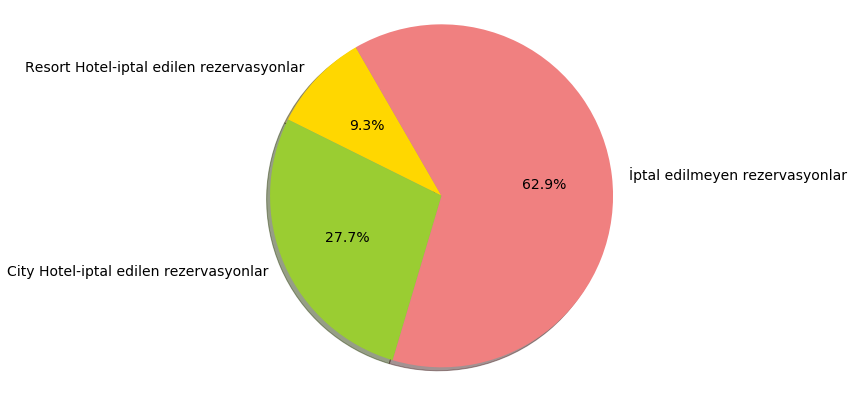

In [136]:
labels = 'Resort Hotel-iptal edilen rezervasyonlar', 'City Hotel-iptal edilen rezervasyonlar', 'İptal edilmeyen rezervasyonlar'
sizes = [resort_cancelation_percent, city_cancelation_percent, 1-(resort_cancelation_percent+city_cancelation_percent)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
fig1, ax1 = plt.subplots(figsize=(8, 7))


plt.pie(sizes,labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=120, textprops={'fontsize': 14})

ax1.axis('equal')
plt.show()

ZİYARETÇİLERİN GELDİĞİ ÜLKELERİ BULUYORUZ

In [137]:
countries_resort = pd.DataFrame(resort_booking.loc[df["is_canceled"] == 0]["country"].value_counts())
countries_resort.rename(columns={"country": "Resort Hotel için Ziyaretçi sayısı"}, inplace=True)
countries_resort["country"] = countries_resort.index

countries_city = pd.DataFrame(city_booking.loc[df["is_canceled"] == 0]["country"].value_counts())
countries_city.rename(columns={"country": "City Hotel için Ziyaretçi sayısı"}, inplace=True)
countries_city["country"] = countries_city.index

In [138]:
fig = px.pie(countries_resort,
             values="Resort Hotel için Ziyaretçi sayısı",
             names="country",
             title="Resort Hotel için ziyaretçilerin ülkelere göre dağılımı",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

fig = px.pie(countries_city,
             values="City Hotel için Ziyaretçi sayısı",
             names="country",
             title="City Hotel için ziyaretçilerin ülkelere göre dağılımı",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()


AYLARA GÖRE ZİYARETÇİ DAĞILIMI

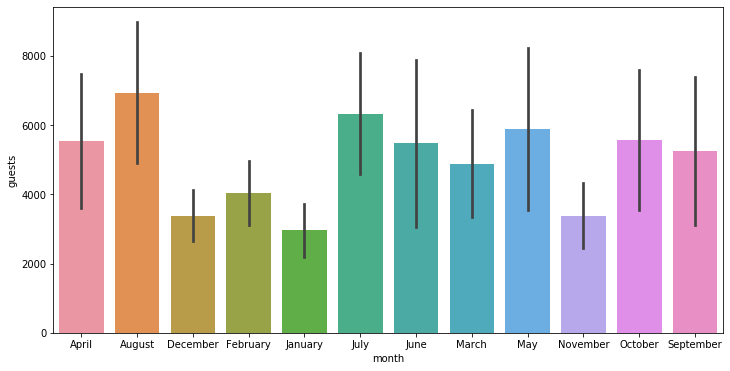

In [167]:
# Create a DateFrame with the relevant data:
resort_guests = df_resort.groupby("arrival_date_month")["hotel"].count()
city_guests = df_city.groupby("arrival_date_month")["hotel"].count()

resort_guest = pd.DataFrame({"month": list(resort_guests.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests.values)})

city_guest = pd.DataFrame({"month": list(city_guests.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests.values)})
total_guest = pd.concat([resort_guest,city_guest], ignore_index=True)

# order by month:
month_to_number={'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12 }
full_guest_data["month"]=full_guest_data["month"].map(month_to_number)

plt.figure(figsize = (12,6))
sns.barplot(x ='month', y = 'guests', data = total_guest)

 KORELASYON MATRİSİ VE GÖRSELLEŞTİRMESİ

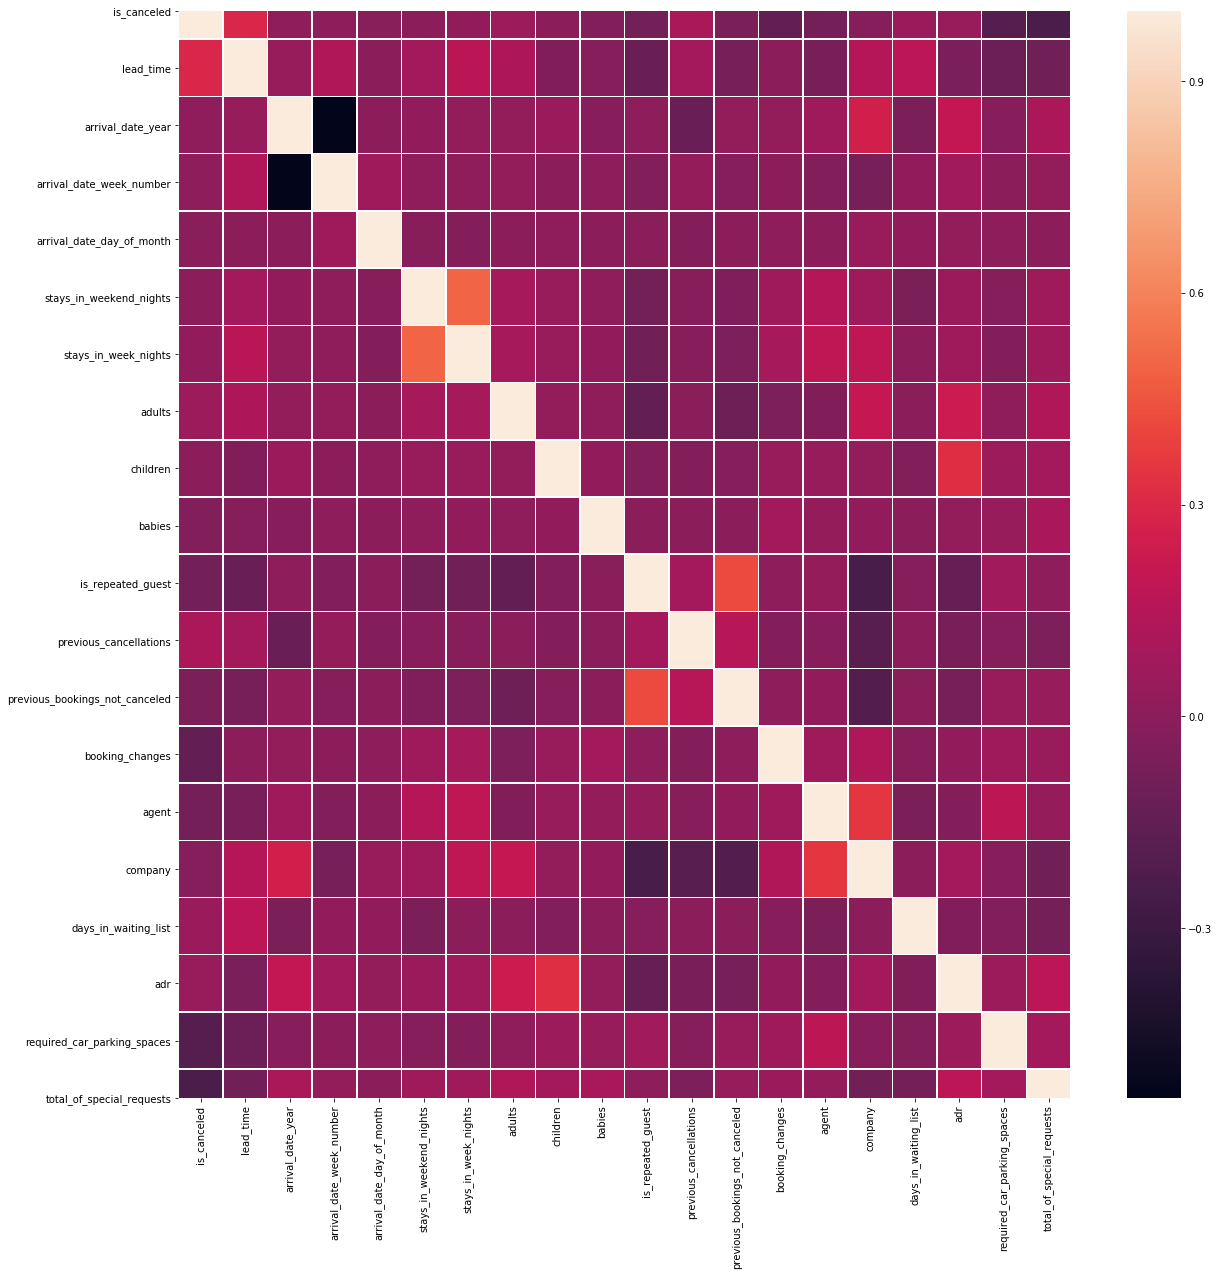

In [170]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, linewidths=.5)

In [171]:
correlation = df.corr()["is_canceled"].sort_values(ascending=False)
correlation

is_canceled                       1.000000
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005048
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
agent                            -0.083114
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

İPTAL EDİLEN REZERVASYONLARI TAHMİN ET

In [194]:
#Modele dair etkisi olmayacağını düşündüğümüz öznitelikleri veri seti içerisinden çıkarıyoruz
df.drop(['arrival_date_month','arrival_date_week_number','meal','agent','company','adr','reservation_status','reservation_status_date'],axis=1,inplace=True)

In [195]:
# pd.get_dummies metodu ile kategorik değerleri nümerik değerlere dönüştürüyoruz
df = pd.get_dummies(df,columns = ['hotel','market_segment', 'distribution_channel', 'reserved_room_type','assigned_room_type','deposit_type','customer_type'],drop_first=True)

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,2015,1,0,0,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,737,2015,1,0,0,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,7,2015,1,0,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,13,2015,1,0,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,14,2015,1,0,2,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [197]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import time, datetime

X = df.drop('is_canceled', axis=1) # Öznitelikler
y = df.is_canceled # Etiketler

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=0)


In [198]:
def ml_algorithm(algorithm, X_train, y_train, cv):
    
    model = algorithm.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Çapraz doğrulama(Cross Validation)
    train_pred = model_selection.cross_val_predict(algorithm, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [202]:
# Lojistik Regresyon
train_pred_log, accuracy_log, acc_cv_log = ml_algorithm(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
print("Lojistik Regresyon: 10-Katlamalı Cross Validation Doğruluğu: %s" % acc_cv_log)

# Random Forest Algoritması
train_pred_rf, acc_rf, acc_cv_rf = ml_algorithm(RandomForestClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
print("Random Forest Algoritması: 10-Katlamalı Cross Validation Doğruluğu: %s" % acc_cv_rf)


# Karar Ağacı Algoritması
train_pred_dt, acc_dt, acc_cv_dt = ml_algorithm(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
print("Karar Ağacı Algoritması: 10-Katlamalı Cross Validation Doğruluğu: %s" % acc_cv_dt)

# k-En yakın Komşuluk
train_pred_knn, acc_knn, acc_cv_knn = ml_algorithm(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
print("k-En yakın Komşuluk: 10-Katlamalı Cross Validation Doğruluğu: %s" % acc_cv_knn)

# Lineer SVC
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = ml_algorithm(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
print("Lineer SVC: 10-Katlamalı Cross Validation Doğruluğu: %s" % acc_cv_linear_svc)

Lojistik Regresyon: 10-Katlamalı Cross Validation Doğruluğu: 80.86
Random Forest Algoritması: 10-Katlamalı Cross Validation Doğruluğu: 84.53
Karar Ağacı Algoritması: 10-Katlamalı Cross Validation Doğruluğu: 81.14
k-En yakın Komşuluk: 10-Katlamalı Cross Validation Doğruluğu: 77.45
Lineer SVC: 10-Katlamalı Cross Validation Doğruluğu: 62.97
